## Create Dataset

In [1]:
from sklearn.datasets import make_moons
from math import floor
import numpy as np

N = 1000
NOISE = 0.1
TRAIN_RATIO = 0.8
x, y = make_moons(n_samples=N, noise=NOISE, shuffle=True, random_state=5)
print(x.shape, y.shape)
xtrain, ytrain = x[:floor(N*TRAIN_RATIO)], y[:floor(N*TRAIN_RATIO)]
xtest, ytest = x[floor(N*TRAIN_RATIO):], y[floor(N*TRAIN_RATIO):]
print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

(1000, 2) (1000,)
(800, 2) (800,) (200, 2) (200,)


## visualize

#### visualize train vs test

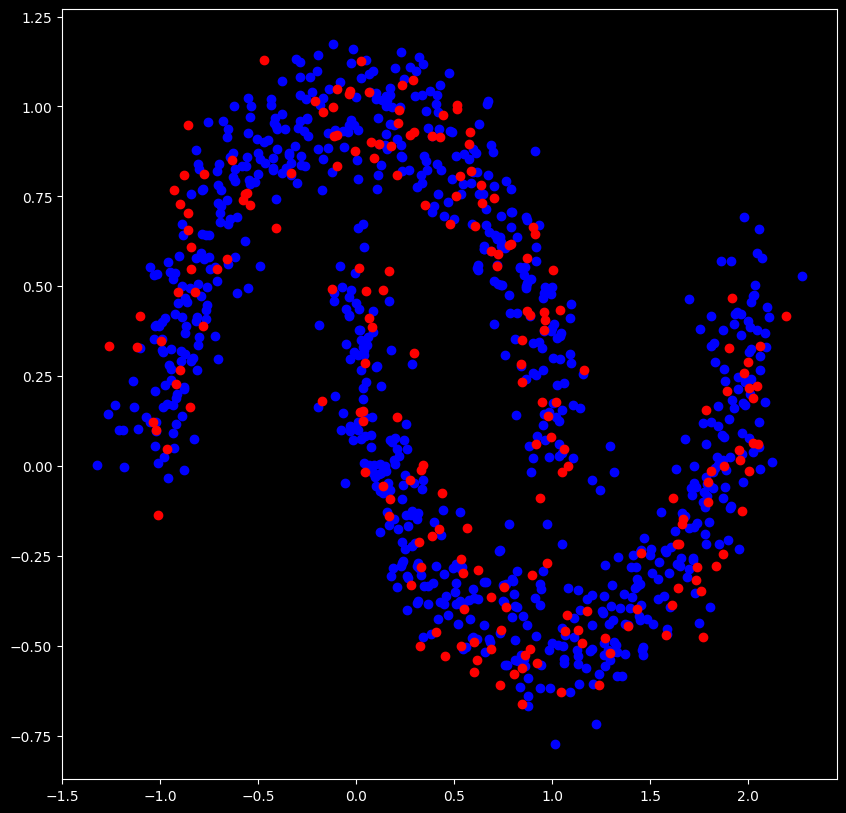

In [2]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1)


plt.plot(xtrain[:,0], xtrain[:,1], 'o', color='blue', label='train')
plt.plot(xtest[:,0], xtest[:,1], 'o', color='red', label='test')


#### Visualize the data per class

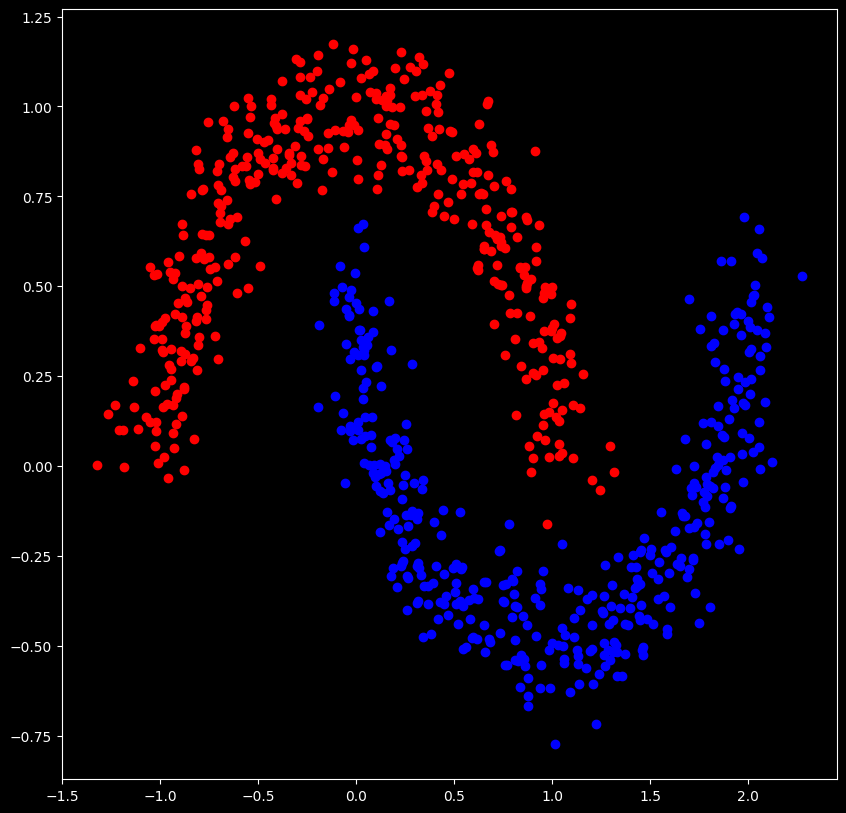

In [17]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1)


plt.plot(xtrain[ytrain==1,0], xtrain[ytrain==1,1], 'o', color='blue', label='class 1')
plt.plot(xtrain[ytrain==0,0], xtrain[ytrain==0,1], 'o', color='red', label='class 0')
# plt.plot(xtest[:,0], xtest[:,1], 'o', color='red', label='test')

## Moving to torch
- why hot encode
  - so we can calculate the cross entropy loss
  - 3 classes -> 3 outputs
    - 0 -> [1,0,0]
    - 1 -> [0,1,0]
    - 2 -> [0,0,1]



In [3]:
import torch

x_train = torch.Tensor(xtrain).float()
y_train = torch.Tensor(ytrain).long()
x_test = torch.Tensor(xtest).float()
y_test = torch.Tensor(ytest).long()
y_train = torch.nn.functional.one_hot(y_train)
y_test = torch.nn.functional.one_hot(y_test)



## Forward pass
- W -> weights
- b -> bias
- X -> input

- Z = X.W + b
  - since W * X is matrix multiplication 
    - we have to ensure that the dimensions match

In [76]:
torch.manual_seed(0)
W = torch.randn(size = (2,2), requires_grad=True)
W.retain_grad()

b = torch.randn(size = (1,2), requires_grad=True)
b.retain_grad()


In [77]:
def predict(X):
    z = X @ W.t() + b
    return torch.softmax(z, dim=1)

predict(torch.randn(size=(100,W.shape[1]))).shape, predict(x_train).shape


(torch.Size([100, 2]), torch.Size([800, 2]))

## Loss function

$$
CE = -\frac{1}{m}\sum_i^m{y_i log(\hat{y_i})}
$$

In [78]:
def CrossEntropy(y_true, y_pred):
    loss = y_true * torch.log(y_pred)
    loss = torch.sum(loss, dim=1)
    loss = torch.mean(loss)
    loss = -loss
    return loss

## Training loop

In [80]:
EPOCHS = 10000
LEARNING_RATE = 0.01
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
for epoch in range(EPOCHS):
    y_pred = predict(x_train)
    loss = CrossEntropy(y_train, y_pred)
    loss.backward()
    with torch.no_grad():
        W -= LEARNING_RATE * W.grad
        b -= LEARNING_RATE * b.grad
        W.grad.zero_()
        b.grad.zero_()
        if epoch % (EPOCHS//10) == 0 or epoch == EPOCHS-1:
            print(f'Epoch {epoch}, Loss {loss.item():.4f}')

Epoch 0, Loss 2.8722
Epoch 1000, Loss 0.3435
Epoch 2000, Loss 0.2988
Epoch 3000, Loss 0.2829
Epoch 4000, Loss 0.2743
Epoch 5000, Loss 0.2691
Epoch 6000, Loss 0.2658
Epoch 7000, Loss 0.2636
Epoch 8000, Loss 0.2620
Epoch 9000, Loss 0.2609
Epoch 9999, Loss 0.2601


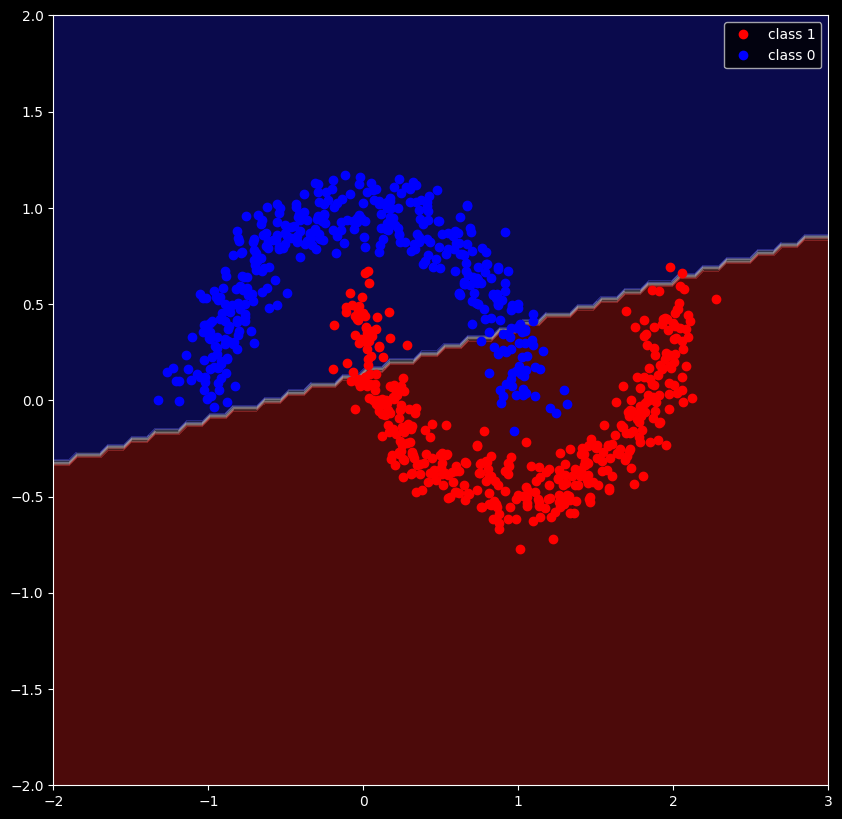

In [92]:
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 1, 1)
plt.plot(xtrain[ytrain==1,0], xtrain[ytrain==1,1], 'o', color='red', label='class 1')
plt.plot(xtrain[ytrain==0,0], xtrain[ytrain==0,1], 'o', color='blue', label='class 0')
x1 = np.linspace(-2, 3, 100)
x2 = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.stack([X1.reshape(-1), X2.reshape(-1)], axis=1)
X = torch.Tensor(X).float()
cmap = plt.get_cmap('bwr')
y = predict(X).argmax(dim=1).reshape(X1.shape)
plt.contourf(X1, X2, y, alpha=0.3, cmap=cmap)
plt.legend()
plt.show()